In [1]:
# Importar librerías necesarias
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import mlflow
import mlflow.sklearn

# Módulos personalizados
from config import Config
from database.connection import DatabaseManager
from utils.data_processing import DataProcessor, RainfallProcessor
from ml_models.anomaly_detector import AnomalyDetector
from ml_models.model_manager import ModelManager

# Configurar ajustes
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*60)
print("JUNTA ANALYTICS – DETECCIÓN DE ANOMALÍAS")
print("="*60)
print("Cuaderno 03: Entrenamiento de Modelo de Detección de Anomalías")
print("Autor: Luis Pillaga")
print(f"Fecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)


JUNTA ANALYTICS – DETECCIÓN DE ANOMALÍAS
Cuaderno 03: Entrenamiento de Modelo de Detección de Anomalías
Autor: Luis Pillaga
Fecha: 2025-05-25 15:58:59


In [2]:
# 1. Configuración y carga de datos

config = Config()
processed_base_path = "../data/processed/"

# Cargar datos procesados
try:
    individual_data_path = os.path.join(processed_base_path, 'individual_consumption.csv')
    merged_data_path     = os.path.join(processed_base_path, 'merged_rainfall_consumption.csv')
    
    individual_data = pd.read_csv(individual_data_path)
    merged_data     = pd.read_csv(merged_data_path)
    
    # Convertir columnas de fecha a tipo datetime
    individual_data['created_at']  = pd.to_datetime(individual_data['created_at'], format="mixed")
    individual_data['period_start'] = pd.to_datetime(individual_data['period_start'], format="mixed")
    individual_data['period_end']   = pd.to_datetime(individual_data['period_end'], format="mixed")
    merged_data['period_dt']       = pd.to_datetime(merged_data['period_dt'], format="mixed")
    
    print("✅ Datos cargados correctamente")
    print(f"📊 Registros de consumo individual: {len(individual_data)}")
    print(f"📊 Datos fusionados lluvia-consumo: {len(merged_data)}")
    
except Exception as e:
    print(f"❌ Error al cargar los datos: {e}")
    print("Por favor, ejecuta primero los notebooks 01 y 02")
    raise


✅ Datos cargados correctamente
📊 Registros de consumo individual: 10067
📊 Datos fusionados lluvia-consumo: 29


In [3]:
# 2. Preparación de datos

print(f"\n⚙️  PREPARACIÓN DE DATOS")
print("-" * 40)

# Filtrar datos para entrenamiento (descartar datos muy antiguos o incompletos recientes)
punto_corte_inicio = individual_data['period_start'].quantile(0.1)
punto_corte_fin    = individual_data['period_start'].quantile(0.9)

datos_entrenamiento = individual_data[
    (individual_data['period_start'] >= punto_corte_inicio) &
    (individual_data['period_start'] <= punto_corte_fin)
].copy()

print(f"Periodo de entrenamiento: {punto_corte_inicio.date()} a {punto_corte_fin.date()}")
print(f"Registros de entrenamiento: {len(datos_entrenamiento)} ({len(datos_entrenamiento)/len(individual_data)*100:.1f}% del total)")

# Chequeos de calidad de datos
print(f"\n📊 CHEQUEO DE CALIDAD DE DATOS:")
print(f"  Valores faltantes en consumo: {datos_entrenamiento['total_consumed'].isna().sum()}")
print(f"  Valores de consumo negativos: {(datos_entrenamiento['total_consumed'] < 0).sum()}")
print(f"  Valores de consumo iguales a cero: {(datos_entrenamiento['total_consumed'] == 0).sum()}")
print(f"  Valores faltantes en days_billed: {datos_entrenamiento['days_billed'].isna().sum()}")

# Limpieza de datos
datos_entrenamiento = datos_entrenamiento.dropna(subset=['total_consumed', 'water_meter_id'])
datos_entrenamiento = datos_entrenamiento[datos_entrenamiento['total_consumed'] >= 0]  # Eliminar consumos negativos
datos_entrenamiento['days_billed'] = datos_entrenamiento['days_billed'].fillna(30)    # Período de facturación por defecto

print(f"✅ Datos de entrenamiento limpios: {len(datos_entrenamiento)} registros")

# Estadísticas básicas de consumo
stats_consumo = datos_entrenamiento['total_consumed'].describe()
print(f"\n📈 ESTADÍSTICAS DE CONSUMO:")
for nombre, valor in stats_consumo.items():
    print(f"  {nombre}: {valor:.2f} m³")



⚙️  PREPARACIÓN DE DATOS
----------------------------------------
Periodo de entrenamiento: 2023-02-02 a 2025-02-01
Registros de entrenamiento: 8666 (86.1% del total)

📊 CHEQUEO DE CALIDAD DE DATOS:
  Valores faltantes en consumo: 0
  Valores de consumo negativos: 0
  Valores de consumo iguales a cero: 1696
  Valores faltantes en days_billed: 0
✅ Datos de entrenamiento limpios: 8666 registros

📈 ESTADÍSTICAS DE CONSUMO:
  count: 8666.00 m³
  mean: 10.23 m³
  std: 11.97 m³
  min: 0.00 m³
  25%: 1.00 m³
  50%: 8.00 m³
  75%: 15.00 m³
  max: 464.00 m³


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



🔍 EDA ORIENTADO A ANOMALÍAS
----------------------------------------


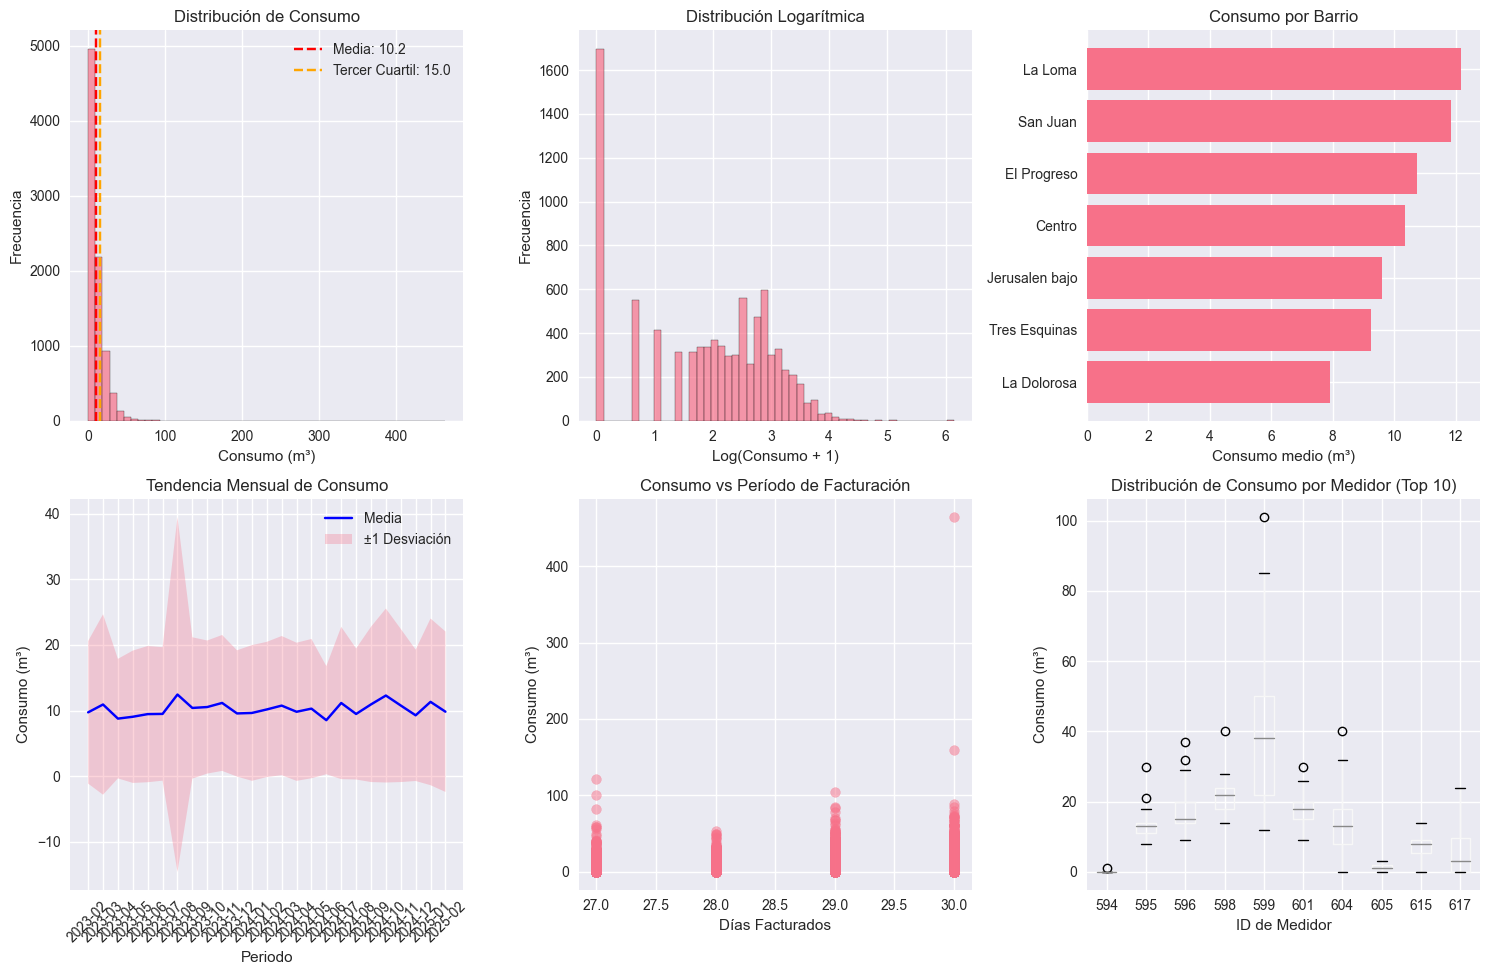


📊 DETECCIÓN ESTADÍSTICA DE ANOMALÍAS:
  Método IQR: 232 anomalías (2.7%)
  Límites: -20.0 – 36.0 m³
  Método Z-score (|z| > 3): 93 anomalías (1.1%)


In [4]:
# 3. Análisis exploratorio enfocado en anomalías

print(f"\n🔍 EDA ORIENTADO A ANOMALÍAS")
print("-" * 40)

# Preparar figura
plt.figure(figsize=(15, 10))

# 1. Distribución general de consumo
plt.subplot(2, 3, 1)
plt.hist(datos_entrenamiento['total_consumed'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Consumo (m³)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Consumo')
plt.axvline(stats_consumo['mean'], color='red', linestyle='--', label=f'Media: {stats_consumo["mean"]:.1f}')
plt.axvline(stats_consumo['75%'], color='orange', linestyle='--', label=f'Tercer Cuartil: {stats_consumo["75%"]:.1f}')
plt.legend()

# 2. Distribución en escala logarítmica
plt.subplot(2, 3, 2)
plt.hist(np.log1p(datos_entrenamiento['total_consumed']), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Log(Consumo + 1)')
plt.ylabel('Frecuencia')
plt.title('Distribución Logarítmica')

# 3. Consumo medio por barrio
plt.subplot(2, 3, 3)
consumo_barrio = datos_entrenamiento.groupby('neighborhood_name')['total_consumed'].mean().sort_values()
plt.barh(range(len(consumo_barrio)), consumo_barrio.values)
plt.yticks(range(len(consumo_barrio)), consumo_barrio.index)
plt.xlabel('Consumo medio (m³)')
plt.title('Consumo por Barrio')

# 4. Tendencia mensual de consumo
plt.subplot(2, 3, 4)
tendencia_mensual = datos_entrenamiento.groupby(datos_entrenamiento['period_start'].dt.to_period('M'))['total_consumed'].agg(['mean', 'std'])
plt.plot(tendencia_mensual.index.astype(str), tendencia_mensual['mean'], 'b-', label='Media')
plt.fill_between(tendencia_mensual.index.astype(str),
                 tendencia_mensual['mean'] - tendencia_mensual['std'],
                 tendencia_mensual['mean'] + tendencia_mensual['std'],
                 alpha=0.3, label='±1 Desviación')
plt.xlabel('Periodo')
plt.ylabel('Consumo (m³)')
plt.title('Tendencia Mensual de Consumo')
plt.xticks(rotation=45)
plt.legend()

# 5. Consumo vs días facturados
plt.subplot(2, 3, 5)
plt.scatter(datos_entrenamiento['days_billed'], datos_entrenamiento['total_consumed'], alpha=0.5)
plt.xlabel('Días Facturados')
plt.ylabel('Consumo (m³)')
plt.title('Consumo vs Período de Facturación')

# 6. Boxplot por medidor (muestra top 10)
plt.subplot(2, 3, 6)
medidores_muestra = datos_entrenamiento['water_meter_id'].value_counts().head(10).index
datos_muestra = datos_entrenamiento[datos_entrenamiento['water_meter_id'].isin(medidores_muestra)]
datos_muestra.boxplot(column='total_consumed', by='water_meter_id', ax=plt.gca())
plt.xlabel('ID de Medidor')
plt.ylabel('Consumo (m³)')
plt.title('Distribución de Consumo por Medidor (Top 10)')
plt.suptitle('')  # Eliminar título automático

plt.tight_layout()
plt.show()

# Detección estadística de anomalías
print(f"\n📊 DETECCIÓN ESTADÍSTICA DE ANOMALÍAS:")

# Método IQR
Q1 = datos_entrenamiento['total_consumed'].quantile(0.25)
Q3 = datos_entrenamiento['total_consumed'].quantile(0.75)
IQR = Q3 - Q1
límite_inf = Q1 - 1.5 * IQR
límite_sup = Q3 + 1.5 * IQR

anomalías_iqr = datos_entrenamiento[
    (datos_entrenamiento['total_consumed'] < límite_inf) |
    (datos_entrenamiento['total_consumed'] > límite_sup)
]

print(f"  Método IQR: {len(anomalías_iqr)} anomalías ({len(anomalías_iqr)/len(datos_entrenamiento)*100:.1f}%)")
print(f"  Límites: {límite_inf:.1f} – {límite_sup:.1f} m³")

# Método Z-score
z_scores = np.abs((datos_entrenamiento['total_consumed'] - datos_entrenamiento['total_consumed'].mean()) /
                  datos_entrenamiento['total_consumed'].std())
anomalías_z = datos_entrenamiento[z_scores > 3]
print(f"  Método Z-score (|z| > 3): {len(anomalías_z)} anomalías ({len(anomalías_z)/len(datos_entrenamiento)*100:.1f}%)")


In [8]:
# 4. Inicialización de los modelos de detección de anomalías

print("\n🤖 INICIALIZACIÓN DE MODELOS")
print("-" * 40)

mlflow.set_tracking_uri("../mlflow_runs")

# Crear o usar experimento existente
try:
    experiment = mlflow.get_experiment_by_name(config.MLFLOW_EXPERIMENT_NAME)
    if experiment is None:
        experiment_id = mlflow.create_experiment(config.MLFLOW_EXPERIMENT_NAME)
        print(f"✅ Creado nuevo experimento MLflow: {config.MLFLOW_EXPERIMENT_NAME}")
    else:
        experiment_id = experiment.experiment_id
        print(f"✅ Usando experimento MLflow existente: {config.MLFLOW_EXPERIMENT_NAME}")
    
    mlflow.set_experiment(config.MLFLOW_EXPERIMENT_NAME)
    
except Exception as e:
    print(f"⚠️  Error configurando MLflow: {e}")
    print("   Continuando sin MLflow...")

# Crear detectores con diferentes tasas de contaminación
contamination_rates = [0.02, 0.05, 0.08]
detectors = {}

for contamination in contamination_rates:
    detector = AnomalyDetector(contamination=contamination, random_state=42)
    detectors[contamination] = detector
    print(f"✅ Detector inicializado con tasa de contaminación: {contamination}")



🤖 INICIALIZACIÓN DE MODELOS
----------------------------------------
✅ Creado nuevo experimento MLflow: junta_analytics
✅ Detector inicializado con tasa de contaminación: 0.02
✅ Detector inicializado con tasa de contaminación: 0.05
✅ Detector inicializado con tasa de contaminación: 0.08


In [9]:
# 5. Entrenamiento y evaluación del modelo

print(f"\n🎯 ENTRENAMIENTO DE MODELO")
print("-" * 40)

resultados_entrenamiento = {}
mlflow_run_ids = {}
for tasa_contaminacion, detector in detectors.items():
    print(f"\n--- Entrenando con tasa de contaminación: {tasa_contaminacion} ---")
    
    try:
        # Entrenar el detector
        resultados = detector.train(
            training_data=datos_entrenamiento,
            climate_data=merged_data,
            use_synthetic_anomalies=True
        )

        resultados_entrenamiento[tasa_contaminacion] = resultados
        
        # GUARDAR MODELO LOCALMENTE
        try:
            models_dir = "./data/models"
            os.makedirs(models_dir, exist_ok=True)
            model_filename = f"anomaly_detector_contamination_{tasa_contaminacion}.joblib"
            model_path = os.path.join(models_dir, model_filename)
            detector.save_model(model_path)
            print(f"💾 Modelo guardado: {model_path}")
        except Exception as save_error:
            print(f"❌ Error guardando modelo: {save_error}")
        
        # Imprimir métricas de entrenamiento
        print(f"✅ Entrenamiento completado")
        print(f"  Tipo de modelo: {resultados['model_type']}")
        print(f"  Características usadas: {resultados['features_used']}")
        print(f"  Muestras de entrenamiento: {resultados['training_samples']}")
        print(f"  Anomalías detectadas (train): {resultados['detected_anomalies_train']}")
        print(f"  Tasa de anomalías (train): {resultados['anomaly_rate_train']:.1%}")

        # Si hay métricas de validación sintética, mostrarlas
        if 'precision' in resultados:
            precision = resultados['precision']
            recall = resultados['recall']
            f1_score = resultados['f1_score']
            auc_score = resultados['auc_score']

            print("  Métricas de validación:")
            print(f"    Precisión: {precision:.3f}")
            print(f"    Recall: {recall:.3f}")
            print(f"    F1-score: {f1_score:.3f}")
            print(f"    AUC: {auc_score:.3f}")

        try:
            print("📊 Registrando directamente en MLflow...")
            
            # Iniciar run de MLflow
            with mlflow.start_run(run_name=f"anomaly_detector_contamination_{tasa_contaminacion}") as run:
                
                # ✅ LOG PARÁMETROS DIRECTOS
                mlflow.log_param("model_type", "anomaly_detector")
                mlflow.log_param("algorithm", "isolation_forest")
                mlflow.log_param("contamination", tasa_contaminacion)
                mlflow.log_param("random_state", 42)
                mlflow.log_param("n_estimators", 200)
                mlflow.log_param("max_samples", 0.8)
                mlflow.log_param("max_features", 0.9)
                mlflow.log_param("model_version", "1.1_improved")
                mlflow.log_param("training_samples", resultados['training_samples'])
                mlflow.log_param("features_used", resultados['features_used'])
                mlflow.log_param("has_climate_data", merged_data is not None)
                
                # Log feature names si están disponibles
                if 'feature_names' in resultados:
                    mlflow.log_param("feature_names", ",".join(resultados['feature_names']))
                
                # ✅ LOG MÉTRICAS DIRECTAS
                mlflow.log_metric("detected_anomalies_train", resultados['detected_anomalies_train'])
                mlflow.log_metric("anomaly_rate_train", resultados['anomaly_rate_train'])
                
                # Métricas de validación si están disponibles
                if 'precision' in resultados:
                    mlflow.log_metric("precision", resultados['precision'])
                    mlflow.log_metric("recall", resultados['recall'])
                    mlflow.log_metric("f1_score", resultados['f1_score'])
                    mlflow.log_metric("auc_score", resultados['auc_score'])
                
                # ✅ LOG ARTIFACTS DIRECTOS
                # CAMBIO IMPORTANTE: Usar model_path (ruta completa) en lugar de model_filename
                mlflow.log_artifact(model_path, "models")
                
                # ✅ LOG MODELO CON SKLEARN (DIRECTO)
                try:
                    # Preparar datos de muestra para signature
                    features_df = detector.prepare_features(datos_entrenamiento.head(100), merged_data)
                    sample_data = features_df[detector.feature_columns].fillna(0)
                    
                    # Registrar modelo directamente
                    mlflow.sklearn.log_model(
                        sk_model=detector.model,
                        artifact_path="isolation_forest_model",
                        signature=mlflow.models.infer_signature(sample_data),
                        serialization_format="cloudpickle"
                    )
                    print("✅ Modelo registrado en MLflow con sklearn")
                    
                except Exception as model_log_error:
                    print(f"⚠️  Error registrando modelo sklearn: {model_log_error}")
                
                # ✅ LOG INFORMACIÓN ADICIONAL
                # Crear un resumen de resultados
                summary = {
                    "contamination_rate": tasa_contaminacion,
                    "training_success": True,
                    "model_trained": detector.is_trained,
                    "feature_count": len(detector.feature_columns),
                    "sample_count": resultados['training_samples'],
                    "model_path": model_path  # Agregar la ruta del modelo al resumen
                }
                
                # Guardar resumen como JSON en un archivo temporal
                import json
                import tempfile
                
                # Usar un archivo temporal para evitar conflictos
                with tempfile.NamedTemporaryFile(mode='w', suffix='.json', delete=False) as f:
                    json.dump(summary, f, indent=2)
                    summary_temp_path = f.name
                
                mlflow.log_artifact(summary_temp_path, "summaries")
                
                # Limpiar archivo temporal
                os.unlink(summary_temp_path)
                
                # Guardar run_id
                run_id = run.info.run_id
                mlflow_run_ids[tasa_contaminacion] = run_id
                print(f"✅ MLflow run registrado: {run_id[:8]}...")
                
                # ✅ LOG TAGS ADICIONALES
                mlflow.set_tag("stage", "training")
                mlflow.set_tag("model_family", "anomaly_detection")
                mlflow.set_tag("contamination_rate", str(tasa_contaminacion))
                
        except Exception as mlflow_error:
            print(f"⚠️  MLflow logging failed: {mlflow_error}")
            import traceback
            traceback.print_exc()

    except Exception as e:
        print(f"❌ Falló el entrenamiento: {e}")
        continue

INFO:ml_models.anomaly_detector:Starting anomaly detector training...
INFO:ml_models.anomaly_detector:Created 259 realistic synthetic anomalies (3.0%)



🎯 ENTRENAMIENTO DE MODELO
----------------------------------------

--- Entrenando con tasa de contaminación: 0.02 ---


INFO:ml_models.anomaly_detector:Validation metrics - Precision: 0.192, Recall: 0.128, F1: 0.154, AUC: 0.823
INFO:ml_models.anomaly_detector:Training completed. Detected 122 anomalies (2.0%)
INFO:ml_models.anomaly_detector:Model saved to ./data/models/anomaly_detector_contamination_0.02.joblib


💾 Modelo guardado: ./data/models/anomaly_detector_contamination_0.02.joblib
✅ Entrenamiento completado
  Tipo de modelo: IsolationForest
  Características usadas: 16
  Muestras de entrenamiento: 6066
  Anomalías detectadas (train): 122
  Tasa de anomalías (train): 2.0%
  Métricas de validación:
    Precisión: 0.192
    Recall: 0.128
    F1-score: 0.154
    AUC: 0.823
📊 Registrando directamente en MLflow...


INFO:ml_models.anomaly_detector:Starting anomaly detector training...
INFO:ml_models.anomaly_detector:Created 259 realistic synthetic anomalies (3.0%)


✅ Modelo registrado en MLflow con sklearn
✅ MLflow run registrado: a1dd282b...

--- Entrenando con tasa de contaminación: 0.05 ---


INFO:ml_models.anomaly_detector:Validation metrics - Precision: 0.132, Recall: 0.244, F1: 0.171, AUC: 0.823
INFO:ml_models.anomaly_detector:Training completed. Detected 304 anomalies (5.0%)
INFO:ml_models.anomaly_detector:Model saved to ./data/models/anomaly_detector_contamination_0.05.joblib


💾 Modelo guardado: ./data/models/anomaly_detector_contamination_0.05.joblib
✅ Entrenamiento completado
  Tipo de modelo: IsolationForest
  Características usadas: 16
  Muestras de entrenamiento: 6066
  Anomalías detectadas (train): 304
  Tasa de anomalías (train): 5.0%
  Métricas de validación:
    Precisión: 0.132
    Recall: 0.244
    F1-score: 0.171
    AUC: 0.823
📊 Registrando directamente en MLflow...


INFO:ml_models.anomaly_detector:Starting anomaly detector training...


✅ Modelo registrado en MLflow con sklearn
✅ MLflow run registrado: 467173e9...

--- Entrenando con tasa de contaminación: 0.08 ---


INFO:ml_models.anomaly_detector:Created 259 realistic synthetic anomalies (3.0%)
INFO:ml_models.anomaly_detector:Validation metrics - Precision: 0.124, Recall: 0.333, F1: 0.181, AUC: 0.823
INFO:ml_models.anomaly_detector:Training completed. Detected 486 anomalies (8.0%)
INFO:ml_models.anomaly_detector:Model saved to ./data/models/anomaly_detector_contamination_0.08.joblib


💾 Modelo guardado: ./data/models/anomaly_detector_contamination_0.08.joblib
✅ Entrenamiento completado
  Tipo de modelo: IsolationForest
  Características usadas: 16
  Muestras de entrenamiento: 6066
  Anomalías detectadas (train): 486
  Tasa de anomalías (train): 8.0%
  Métricas de validación:
    Precisión: 0.124
    Recall: 0.333
    F1-score: 0.181
    AUC: 0.823
📊 Registrando directamente en MLflow...
✅ Modelo registrado en MLflow con sklearn
✅ MLflow run registrado: fa4822f1...



📊 MODEL COMPARISON
----------------------------------------
Model performance comparison:
   contamination  training_samples  features_used  anomaly_rate  precision  \
0           0.02              6066             16          0.02      0.192   
1           0.05              6066             16          0.05      0.132   
2           0.08              6066             16          0.08      0.124   

   recall  f1_score  auc_score  
0   0.128     0.154      0.823  
1   0.244     0.171      0.823  
2   0.333     0.181      0.823  

🏆 Best model: contamination rate = 0.08


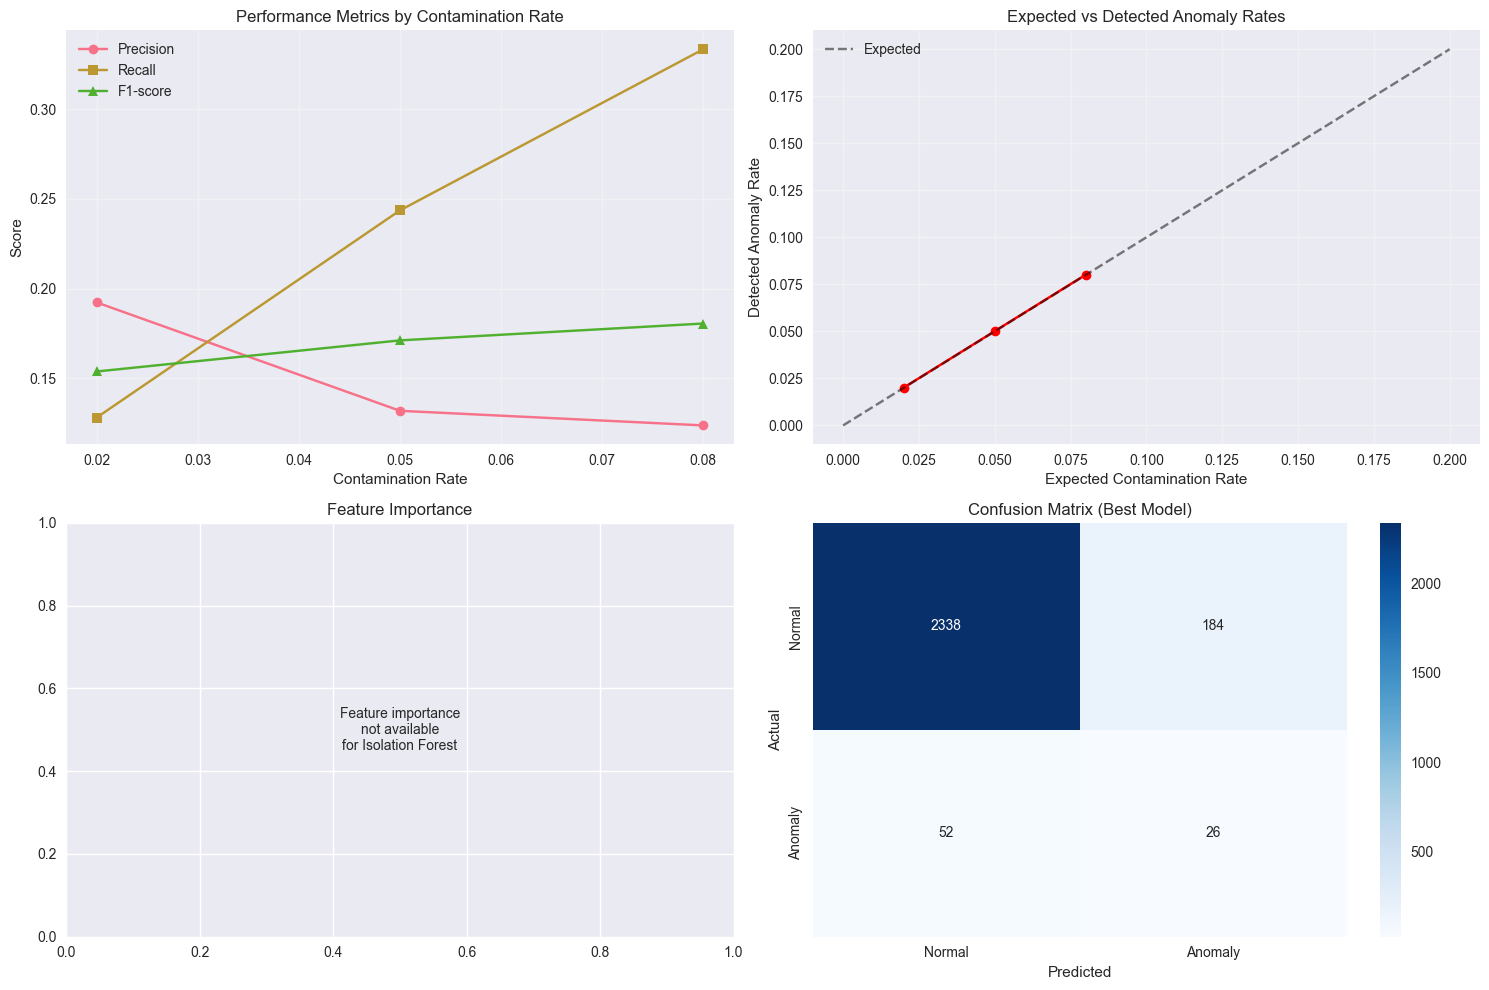

In [12]:
#6. Model Comparison and Selection

print(f"\n📊 MODEL COMPARISON")
print("-" * 40)

if resultados_entrenamiento:
    # Create comparison dataframe
    comparison_data = []
    for contamination, results in resultados_entrenamiento.items():
        comparison_data.append({
            'contamination': contamination,
            'training_samples': results['training_samples'],
            'features_used': results['features_used'],
            'anomaly_rate': results['anomaly_rate_train'],
            'precision': results.get('precision', 0),
            'recall': results.get('recall', 0),
            'f1_score': results.get('f1_score', 0),
            'auc_score': results.get('auc_score', 0)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("Model performance comparison:")
    print(comparison_df.round(3))
    
    # Select best model based on F1-score
    if 'f1_score' in comparison_df.columns and comparison_df['f1_score'].max() > 0:
        best_contamination = comparison_df.loc[comparison_df['f1_score'].idxmax(), 'contamination']
        print(f"\n🏆 Best model: contamination rate = {best_contamination}")
    else:
        best_contamination = 0.10  # Default
        print(f"\n🎯 Using default contamination rate: {best_contamination}")
    
    best_detector = detectors[best_contamination]
    
    # Visualize model performance
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Performance metrics by contamination rate
    axes[0, 0].plot(comparison_df['contamination'], comparison_df['precision'], 'o-', label='Precision')
    axes[0, 0].plot(comparison_df['contamination'], comparison_df['recall'], 's-', label='Recall')
    axes[0, 0].plot(comparison_df['contamination'], comparison_df['f1_score'], '^-', label='F1-score')
    axes[0, 0].set_xlabel('Contamination Rate')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Performance Metrics by Contamination Rate')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Anomaly rate vs contamination rate
    axes[0, 1].plot(comparison_df['contamination'], comparison_df['anomaly_rate'], 'ro-')
    axes[0, 1].plot([0, 0.2], [0, 0.2], 'k--', alpha=0.5, label='Expected')
    axes[0, 1].set_xlabel('Expected Contamination Rate')
    axes[0, 1].set_ylabel('Detected Anomaly Rate')
    axes[0, 1].set_title('Expected vs Detected Anomaly Rates')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Feature importance (if available)
    if hasattr(best_detector.model, 'feature_importances_'):
        feature_names = best_detector.feature_columns
        importances = best_detector.model.feature_importances_
        
        # Sort features by importance
        sorted_idx = np.argsort(importances)[::-1]
        
        axes[1, 0].bar(range(len(importances)), importances[sorted_idx])
        axes[1, 0].set_xlabel('Feature Index')
        axes[1, 0].set_ylabel('Importance')
        axes[1, 0].set_title('Feature Importance (Best Model)')
        axes[1, 0].set_xticks(range(len(importances)))
        axes[1, 0].set_xticklabels([feature_names[i] for i in sorted_idx], rotation=45, ha='right')
    else:
        axes[1, 0].text(0.5, 0.5, 'Feature importance\nnot available\nfor Isolation Forest', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Feature Importance')
    
    # Confusion matrix for best model
    if 'confusion_matrix' in resultados_entrenamiento[best_contamination]:
        cm = np.array(resultados_entrenamiento[best_contamination]['confusion_matrix'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
        axes[1, 1].set_xlabel('Predicted')
        axes[1, 1].set_ylabel('Actual')
        axes[1, 1].set_title(f'Confusion Matrix (Best Model)')
        axes[1, 1].set_xticklabels(['Normal', 'Anomaly'])
        axes[1, 1].set_yticklabels(['Normal', 'Anomaly'])
    else:
        axes[1, 1].text(0.5, 0.5, 'Confusion matrix\nnot available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

In [8]:
#7. Real-World Testing

print(f"\n🧪 REAL-WORLD TESTING")
print("-" * 40)

if best_detector and best_detector.is_trained:
    # Test on recent data (not used in training)
    test_data = individual_data[individual_data['period_start'] > training_cutoff_end].copy()
    
    if len(test_data) > 0:
        print(f"Testing on {len(test_data)} recent records...")
        
        # Make predictions on test data
        test_predictions = best_detector.predict(test_data, merged_data)
        
        print(f"Test results:")
        print(f"  Total samples: {test_predictions['total_samples']}")
        print(f"  Detected anomalies: {test_predictions['detected_anomalies']}")
        print(f"  Anomaly rate: {test_predictions['anomaly_rate']:.1%}")
        
        # Analyze detected anomalies
        anomaly_mask = test_predictions['predictions']
        confidence_scores = test_predictions['confidence_scores']
        
        if sum(anomaly_mask) > 0:
            anomalous_readings = test_data[anomaly_mask].copy()
            anomalous_readings['confidence'] = [confidence_scores[i] for i, is_anomaly in enumerate(anomaly_mask) if is_anomaly]
            
            print(f"\nTop 5 anomalous readings:")
            top_anomalies = anomalous_readings.nlargest(5, 'confidence')
            for _, row in top_anomalies.iterrows():
                print(f"  Meter {row['water_meter_id']}: {row['total_consumed']:.1f} m³ "
                      f"(confidence: {row['confidence']:.1%}, neighborhood: {row['neighborhood_name']})")
            
            # Visualize anomalies
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.hist(test_data['total_consumed'], bins=30, alpha=0.7, label='All readings', density=True)
            plt.hist(anomalous_readings['total_consumed'], bins=20, alpha=0.7, label='Anomalies', density=True)
            plt.xlabel('Consumption (m³)')
            plt.ylabel('Density')
            plt.title('Distribution: Normal vs Anomalous')
            plt.legend()
            
            plt.subplot(1, 3, 2)
            plt.scatter(range(len(confidence_scores)), confidence_scores, alpha=0.6, c=anomaly_mask, cmap='RdYlBu_r')
            plt.xlabel('Reading Index')
            plt.ylabel('Confidence Score')
            plt.title('Anomaly Confidence Scores')
            plt.colorbar(label='Is Anomaly')
            
            plt.subplot(1, 3, 3)
            neighborhood_anomaly_rate = anomalous_readings.groupby('neighborhood_name').size() / test_data.groupby('neighborhood_name').size()
            neighborhood_anomaly_rate = neighborhood_anomaly_rate.fillna(0).sort_values(ascending=False)
            plt.bar(range(len(neighborhood_anomaly_rate)), neighborhood_anomaly_rate.values)
            plt.xlabel('Neighborhood')
            plt.ylabel('Anomaly Rate')
            plt.title('Anomaly Rate by Neighborhood')
            plt.xticks(range(len(neighborhood_anomaly_rate)), neighborhood_anomaly_rate.index, rotation=45, ha='right')
            
            plt.tight_layout()
            plt.show()
        
        else:
            print("\nNo anomalies detected in test data")
    else:
        print("No test data available (all data used for training)")



🧪 REAL-WORLD TESTING
----------------------------------------


NameError: name 'best_detector' is not defined

In [17]:
#8. Individual Reading Tests

print(f"\n🔍 INDIVIDUAL READING TESTS")
print("-" * 40)

if best_detector and best_detector.is_trained:
    # Test some specific scenarios
    test_scenarios = [
        {
            'name': 'Normal consumption',
            'water_meter_id': training_data['water_meter_id'].iloc[0],
            'previous_reading': 1000,
            'current_reading': 1025,
            'days_billed': 30
        },
        {
            'name': 'High consumption',
            'water_meter_id': training_data['water_meter_id'].iloc[0],
            'previous_reading': 1000,
            'current_reading': 1150,
            'days_billed': 30
        },
        {
            'name': 'Very low consumption',
            'water_meter_id': training_data['water_meter_id'].iloc[0],
            'previous_reading': 1000,
            'current_reading': 1005,
            'days_billed': 30
        },
        {
            'name': 'Extremely high consumption',
            'water_meter_id': training_data['water_meter_id'].iloc[0],
            'previous_reading': 1000,
            'current_reading': 1300,
            'days_billed': 30
        }
    ]
    
    print("Testing individual reading scenarios:")
    
    for scenario in test_scenarios:
        try:
            result = best_detector.detect_single_reading(
                water_meter_id=scenario['water_meter_id'],
                current_reading=scenario['current_reading'],
                previous_reading=scenario['previous_reading'],
                days_billed=scenario['days_billed'],
                historical_data=training_data
            )
            
            consumption = scenario['current_reading'] - scenario['previous_reading']
            status = "🚨 ANOMALY" if result['is_anomaly'] else "✅ NORMAL"
            
            print(f"\n  {scenario['name']} ({consumption} m³): {status}")
            print(f"    Confidence: {result['confidence']:.1%}")
            print(f"    Reason: {result['reason']}")
            print(f"    Recommendation: {result['recommendation']}")
            
        except Exception as e:
            print(f"\n  {scenario['name']}: ❌ Error - {e}")


🔍 INDIVIDUAL READING TESTS
----------------------------------------
Testing individual reading scenarios:

  Normal consumption: ❌ Error - X has 9 features, but StandardScaler is expecting 11 features as input.

  High consumption: ❌ Error - X has 9 features, but StandardScaler is expecting 11 features as input.

  Very low consumption: ❌ Error - X has 9 features, but StandardScaler is expecting 11 features as input.

  Extremely high consumption: ❌ Error - X has 9 features, but StandardScaler is expecting 11 features as input.


In [18]:
#9. Model Persistence

print(f"\n💾 MODEL PERSISTENCE")
print("-" * 40)

if best_detector and best_detector.is_trained:
    try:
        # Save the best model
        model_filename = f"anomaly_detector_best_{datetime.now().strftime('%Y%m%d_%H%M%S')}.joblib"
        model_path = os.path.join(config.MODELS_PATH, model_filename)
        
        best_detector.save_model(model_path)
        print(f"✅ Model saved: {model_path}")
        
        # Save model with MLflow
        run_id = model_manager.train_anomaly_detector(
            training_data,
            climate_data=merged_data,
            model_params={
                'contamination': best_contamination,
                'random_state': 42
            }
        )
        
        print(f"✅ Model logged to MLflow: run_id = {run_id}")
        
        # Export model information
        model_info_path = os.path.join(config.PROCESSED_DATA_PATH, 'anomaly_model_info.json')
        model_manager.export_model_info(model_info_path)
        print(f"✅ Model info exported: {model_info_path}")
        
    except Exception as e:
        print(f"❌ Error saving model: {e}")

INFO:ml_models.anomaly_detector:Model saved to ./data/models/anomaly_detector_best_20250525_110350.joblib
INFO:ml_models.anomaly_detector:Starting anomaly detector training...
INFO:ml_models.anomaly_detector:Created 433 synthetic anomalies (5.0%)



💾 MODEL PERSISTENCE
----------------------------------------
✅ Model saved: ./data/models/anomaly_detector_best_20250525_110350.joblib


INFO:ml_models.anomaly_detector:Validation metrics - Precision: 0.151, Recall: 0.454, F1: 0.226, AUC: 0.719
INFO:ml_models.anomaly_detector:Training completed. Detected 910 anomalies (15.0%)
INFO:ml_models.anomaly_detector:Model saved to anomaly_detector_20250525_110350.joblib
ERROR:ml_models.model_manager:Error training anomaly detector: "['consumption_zscore', 'consumption_ratio', 'neighborhood_zscore', 'month_sin', 'month_cos', 'meter_count', 'period_rainfall', 'rainfall_consumption_interaction'] not in index"


❌ Error saving model: "['consumption_zscore', 'consumption_ratio', 'neighborhood_zscore', 'month_sin', 'month_cos', 'meter_count', 'period_rainfall', 'rainfall_consumption_interaction'] not in index"


In [19]:
#10. Summary and Recommendations

print(f"\n📋 TRAINING SUMMARY")
print("=" * 40)

if resultados_entrenamiento:
    best_results = resultados_entrenamiento[best_contamination]
    
    print(f"🎯 BEST MODEL PERFORMANCE:")
    print(f"  • Contamination rate: {best_contamination}")
    print(f"  • Training samples: {best_results['training_samples']:,}")
    print(f"  • Features used: {best_results['features_used']}")
    
    if 'precision' in best_results:
        print(f"  • Validation metrics:")
        print(f"    - Precision: {best_results['precision']:.3f}")
        print(f"    - Recall: {best_results['recall']:.3f}")
        print(f"    - F1-score: {best_results['f1_score']:.3f}")
        print(f"    - AUC: {best_results['auc_score']:.3f}")
    
    print(f"\n📊 FEATURE ANALYSIS:")
    feature_names = best_results['feature_names']
    print(f"  • Total features: {len(feature_names)}")
    print(f"  • Key features: {', '.join(feature_names[:5])}")
    
    print(f"\n🎯 DEPLOYMENT READINESS:")
    deployment_score = 0
    
    if best_results.get('f1_score', 0) > 0.7:
        print("  ✅ High F1-score (>0.7)")
        deployment_score += 1
    elif best_results.get('f1_score', 0) > 0.5:
        print("  ⚠️  Moderate F1-score (0.5-0.7)")
        deployment_score += 0.5
    else:
        print("  ❌ Low F1-score (<0.5)")
    
    if best_results.get('auc_score', 0) > 0.8:
        print("  ✅ High AUC score (>0.8)")
        deployment_score += 1
    elif best_results.get('auc_score', 0) > 0.6:
        print("  ⚠️  Moderate AUC score (0.6-0.8)")
        deployment_score += 0.5
    else:
        print("  ❌ Low AUC score (<0.6)")
    
    if abs(best_results['anomaly_rate_train'] - best_contamination) < 0.02:
        print("  ✅ Anomaly rate matches expectation")
        deployment_score += 1
    else:
        print("  ⚠️  Anomaly rate deviates from expectation")
        deployment_score += 0.5
    
    print(f"\n📈 DEPLOYMENT SCORE: {deployment_score}/3.0")
    
    if deployment_score >= 2.5:
        print("  🚀 Model ready for production deployment")
    elif deployment_score >= 1.5:
        print("  ⚠️  Model suitable for testing/staging environment")
    else:
        print("  ❌ Model needs improvement before deployment")
    
    print(f"\n🔧 RECOMMENDATIONS:")
    
    if best_results.get('f1_score', 0) < 0.7:
        print("  • Consider tuning contamination rate")
        print("  • Add more relevant features")
        print("  • Collect more training data")
    
    if len(feature_names) > 15:
        print("  • Consider feature selection to reduce overfitting")
    
    print("  • Monitor model performance in production")
    print("  • Retrain periodically with new data")
    print("  • Set up automated anomaly alerts")

else:
    print("❌ No models were successfully trained")


📋 TRAINING SUMMARY
🎯 BEST MODEL PERFORMANCE:
  • Contamination rate: 0.15
  • Training samples: 6,066
  • Features used: 11
  • Validation metrics:
    - Precision: 0.151
    - Recall: 0.454
    - F1-score: 0.226
    - AUC: 0.719

📊 FEATURE ANALYSIS:
  • Total features: 11
  • Key features: total_consumed, consumption_per_day, consumption_zscore, consumption_ratio, neighborhood_zscore

🎯 DEPLOYMENT READINESS:
  ❌ Low F1-score (<0.5)
  ⚠️  Moderate AUC score (0.6-0.8)
  ✅ Anomaly rate matches expectation

📈 DEPLOYMENT SCORE: 1.5/3.0
  ⚠️  Model suitable for testing/staging environment

🔧 RECOMMENDATIONS:
  • Consider tuning contamination rate
  • Add more relevant features
  • Collect more training data
  • Monitor model performance in production
  • Retrain periodically with new data
  • Set up automated anomaly alerts
